In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

# LLM-as-a-Judge

> In this notebook, we will filter out data using LLMs

- skip_showdoc: true
- skip_exec: true

In [ ]:
#| default_exp llm_as_judge

### Config

In [ ]:
from claimdb.configuration import *
import json
from pydantic import BaseModel, Field
from typing import Literal
from claimdb.preprocess_bird import *
from openai import OpenAI
from claimdb.configuration import *

In [ ]:
endpoint = "https://agenticllms.cognitiveservices.azure.com/openai/v1/"

client = OpenAI(
    base_url=f"{endpoint}",
    api_key=config.openai_api_key_from_azure
)

Main Insights:

- The `response_format` is forced

- The descriptions of the `Field` are not inserted into the prompt (at least for DeepSeek V3.1). OpenAI's models do include them -- and agents too.
   - This means we have to explain the output format in the system prompt. We will always include them because it is undocumented behavior. OpenAI's models are safe in this regard (they are managed by OpenAI after all).


## Prompt and Response Schema

In [ ]:
#| export
from claimdb.configuration import *
import json
from pydantic import BaseModel, Field
from typing import Literal
from claimdb.preprocess_bird import *
from claimdb.configuration import *
import time

### Schemas I/O

In [ ]:
#| export
class ClaimQuality(BaseModel):
    label_correct: Literal["yes", "no"] = Field(
        ..., 
        description="Is the assigned label of the claim (ENTAILED/CONTRADICTED) correct given the gold information? Answer \"yes\" if the label of the claim follows from the gold information; \"no\" otherwise. If you are unsure, answer \"no\"."
    )

    free_of_meta_references: Literal["yes", "no"] = Field(
        ...,
        description="Does the claim avoid meta-references to the question, answer, or prior text (e.g., \"this question\", \"the answer above\", \"as mentioned earlier\")? Answer \"yes\" if it is completely free of meta-references; \"no\" otherwise. References to provided external knowledge do not count as meta-references."
    )
    
    reasoning: str = Field(
        ...,
        description="Brief explanation (1-2 sentences) justifying your evaluation (especially for \"label_correct\")."
    )
    def __eq__(self, other):
        """Compare all fields except reasoning."""
        return (
            self.label_correct == other.label_correct
            and self.free_of_meta_references == other.free_of_meta_references
        )

In [ ]:
#| export
class NEIClaimQuality(BaseModel):
    label_correct: Literal["yes", "no"] = Field(
        ..., 
        description="Is the assigned label of the claim (NOT ENOUGH INFO) correct given the gold information? Answer \"yes\" if the label of the claim follows from the gold information; \"no\" otherwise. If you are unsure, answer \"no\"."
    )

    free_of_meta_references: Literal["yes", "no"] = Field(
        ...,
        description="Does the claim avoid meta-references to the question, answer, or prior text (e.g., \"this question\", \"the answer above\", \"as mentioned earlier\")? Answer \"yes\" if it is completely free of meta-references; \"no\" otherwise. References to provided external knowledge do not count as meta-references."
    )

    category_correct: Literal["yes", "no"] = Field(
        ..., 
        description="Is the assigned category of the claim (OUT-OF-SCHEMA/COUNTERFACTUAL/SUBJECTIVE) correct given the gold information? Answer \"yes\" if the category of the claim follows from the gold information; \"no\" otherwise."
    )

    schema_leakage: Literal["yes", "no"] = Field(
        ...,
        description="Does the claim expose database schema details or technical artifacts? Answer \"yes\" if it exposes schema details (e.g., table names, column names, etc.); \"no\" if it does not."
    )
    
    reasoning: str = Field(
        ...,
        description="Brief explanation (1-2 sentences) justifying your evaluation (especially for \"label_correct\" and \"category_correct\")."
    )

    def __eq__(self, other):
        """Compare all fields except reasoning."""
        return (
            self.label_correct == other.label_correct
            and self.free_of_meta_references == other.free_of_meta_references
            and self.category_correct == other.category_correct
            and self.schema_leakage == other.schema_leakage
        )

### Prompts

In [ ]:
#| export
regular_system_prompt =f"""
Your task is to evaluate a natural-language claim across two criteria. You will be given a gold context composed of a question, its answer, the domain, and optional external knowledge. Treat the gold context as the authoritative ground truth.

You will be given a claim labeled as either ENTAILED (supported by the gold context) or CONTRADICTED (refuted by the gold context). Using this gold information, assess whether the claim is correctly labeled, and whether it is free of meta-references. More detailed instructions for the two evaluation criteria are provided along with the JSON schema below.

Your answer should be in JSON format, adhering to the following schema:
{json.dumps(ClaimQuality.model_json_schema(), indent=2)}
"""

In [ ]:
print(regular_system_prompt)


Your task is to evaluate a natural-language claim across two criteria. You will be given a gold context composed of a question, its answer, the domain, and optional external knowledge. Treat the gold context as the authoritative ground truth.

You will be given a claim labeled as either ENTAILED (supported by the gold context) or CONTRADICTED (refuted by the gold context). Using this gold information, assess whether the claim is correctly labeled, and whether it is free of meta-references. More detailed instructions for the two evaluation criteria are provided along with the JSON schema below.

Your answer should be in JSON format, adhering to the following schema:
{
  "properties": {
    "label_correct": {
      "description": "Is the assigned label of the claim (ENTAILED/CONTRADICTED) correct given the gold information? Answer \"yes\" if the label of the claim follows from the gold information; \"no\" otherwise. If you are unsure, answer \"no\".",
      "enum": [
        "yes",
    

In [ ]:
#| export
nei_system_prompt =f"""
Your task is to evaluate a natural-language claim across several criteria. You will be given a gold context composed of a question, its answer, the domain, optional external knowledge, and the complete database schema underlying the gold context. Treat the gold context as the authoritative ground truth.

You will be given a claim with an assigned NOT ENOUGH INFO (NEI) label, meaning that its truth cannot be determined from the gold context, even with full access to the database. The claim is also assigned an NEI category: OUT-OF-SCHEMA (depends on information not stored in the database), SUBJECTIVE (expresses opinions or judgments), or COUNTERFACTUAL (describes hypothetical scenarios). Using the gold context, assess whether the NEI label and category are correct, whether the claim is free of meta-references, and whether it leaks schema details of the database. More detailed descriptions for each evaluation criterion are provided in the JSON schema below.

Your answer should be in JSON format, adhering to the following schema:
{json.dumps(NEIClaimQuality.model_json_schema(), indent=2)}
"""

In [ ]:
print(nei_system_prompt)


Your task is to evaluate a natural-language claim across several criteria. You will be given a gold context composed of a question, its answer, the domain, optional external knowledge, and the complete database schema underlying the gold context. Treat the gold context as the authoritative ground truth.

You will be given a claim with an assigned NOT ENOUGH INFO (NEI) label, meaning that its truth cannot be determined from the gold context, even with full access to the database. The claim is also assigned an NEI category: OUT-OF-SCHEMA (depends on information not stored in the database), SUBJECTIVE (expresses opinions or judgments), or COUNTERFACTUAL (describes hypothetical scenarios). Using the gold context, assess whether the NEI label and category are correct, whether the claim is free of meta-references, and whether it leaks schema details of the database. More detailed descriptions for each evaluation criterion are provided in the JSON schema below.

Your answer should be in JSON

## Load Claims

In [ ]:
ec_claims = []
nei_claims = []

with open(config.output_data_dir / "all_claims.jsonl", "r") as f:
    for line in f.readlines():
        claim = json.loads(line)
        if claim['label'] == 'NOT ENOUGH INFO':
            nei_claims.append(claim)
        else:
            ec_claims.append(claim)

In [ ]:
len(ec_claims), len(nei_claims)

(33187, 28831)

In [ ]:
bird_id_example_map = dict()

with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    for line in f:
        example = json.loads(line)
        bird_id_example_map[example['bird_id']] = example

## Human Annotations (300 ex)

### Load 150 EC + 150 NEI

In [ ]:
import random
random.seed(42)

In [ ]:
ec_examples = random.sample(ec_claims, 150)
nei_examples = random.sample(nei_claims, 150)

In [ ]:
ec_examples[20]

{'bird_id': 9568,
 'claim_id': 56230,
 'db_name': 'university',
 'claim': 'In 2011, Alexandria University enrolled more students than any other university.',
 'extra_info': 'in 2011 refers to year = 2011; had the most students refers to MAX(num_students); name of university refers to university_name;',
 'label': 'ENTAILED'}

### Create Jupyter Form to Submit Quickly

In [ ]:
from ipywidgets import widgets, Layout, VBox
from IPython.display import display, clear_output

def get_manual_evaluation_form(model_class: type[BaseModel]):
    """Simplified form that returns the model instance when submitted."""
    field_widgets = {}
    widget_list = []
    
    for field_name, field_info in model_class.model_fields.items():
        desc = field_info.description or field_name
        
        if field_name == "reasoning":
            field_widgets[field_name] = widgets.Textarea(
                description=field_name + ":",
                placeholder='1-2 sentences',
                layout=Layout(width='90%', height='80px')
            )
        else:
            field_widgets[field_name] = widgets.RadioButtons(
                options=['yes', 'no'],
                description=field_name + ":",
                layout=Layout(width='90%')
            )
        
        # Add description as label
        widget_list.append(widgets.HTML(f"<i>{desc}</i>"))
        widget_list.append(field_widgets[field_name])
    
    submit = widgets.Button(description='Submit', button_style='success')
    output = widgets.Output()
    
    result = {}
    
    def on_submit(b):
        with output:
            clear_output()
            fields = {name: w.value for name, w in field_widgets.items()}
            result['model'] = model_class(**fields)
            print("✅ Submitted:", result['model'])
    
    submit.on_click(on_submit)
    display(VBox(widget_list + [submit, output]))
    
    return result

#### Example of Form

In [ ]:
result = get_manual_evaluation_form(ClaimQuality)

In [ ]:
result['model']

ClaimQuality(label_correct='yes', free_of_meta_references='yes', reasoning='')

### Manually Annotate Examples

This is not a usual jupyter code block. the idea is to run manually cells and go back again and run again.

First we load all our examples that we want to label in a single list.

In [ ]:
all_examples = ec_examples + nei_examples
num_examples = len(all_examples)

NameError: name 'ec_examples' is not defined

In [ ]:
all_examples[0]

{'bird_id': 8912,
 'claim_id': 52786,
 'db_name': 'works_cycles',
 'claim': 'In Works Cycles, 80 people have projected yearly sales of no more than 50,000.',
 'extra_info': 'projected yearly sales refers to SalesQuota; SalesQuota< = 50000;',
 'label': 'ENTAILED'}

In [ ]:
len(all_examples)

300

**Here, we run again and again the following 4 code blocks to label all examples.** The following cells are meant to be run on repeat until all examples are labeled. Also, we use `ipywidgets` to create buttons to label quickly which might not render to the final notebook. In order to understand what is going on, we advise to run the notebook!

Essentially, we create a nice form that you can choose `yes` or `no`, and also write the `reasoning` in a text box and then click `submit` to label the example. Otherwise the process would have been super painful.

In [ ]:
print(f"Processing example {num_examples - len(all_examples) + 1} of {num_examples}")
print("-" * 50)

if all_examples:
    claim = all_examples.pop(0)
    claim_id = claim['claim_id']
    bird_example = bird_id_example_map[claim['bird_id']]

    info = {'claim_id': claim_id, 'label': claim['label']}

    if claim['label'] == 'NOT ENOUGH INFO':
        info['category'] = claim['category']

        print("Golden Information:")
        inp = format_for_llm(prepare_bird_example(bird_example, with_schema=True))
        for k, v in json.loads(inp).items(): print(f"{k}: {v}")
        print(f"\n\nClaim to Evaluate: {claim['claim']}")
        print(f"Assigned Label: {claim['label']}")
        print(f"Assigned Category: {claim['category']}")
        result = get_manual_evaluation_form(NEIClaimQuality)
        
    else:
        print("Golden Information:")
        inp = format_for_llm(prepare_bird_example(bird_example))
        for k, v in json.loads(inp).items(): print(f"{k}: {v}")
        print(f"\n\nClaim to Evaluate: {claim['claim']}\n")
        print(f"Assigned Label: {claim['label']}")
        result = get_manual_evaluation_form(ClaimQuality)

Processing example 4 of 300
--------------------------------------------------
Golden Information:
question: How many person have a projected yearly sales of no more than 50,000?
answer: [{'COUNT(BusinessEntityID)': 80}]
domain: Works Cycles
external-knowledge: projected yearly sales refers to SalesQuota; SalesQuota< = 50000;


Claim to Evaluate: In Works Cycles, 80 people have projected yearly sales of no more than 50,000.

Assigned Label: ENTAILED


In [ ]:
if result: 
    parsed = result['model'].model_dump()
    final = info | parsed
    print(json.dumps(final, indent=2))

{
  "claim_id": 52786,
  "label": "ENTAILED",
  "label_correct": "yes",
  "free_of_meta_references": "yes",
  "reasoning": ""
}


In [ ]:
with open(config.judges_dir / f"human_annotations.jsonl", "a") as f:
    f.write(json.dumps(final) + "\n")

with open(config.judges_dir / f"human_annotations.jsonl", "r") as f:
    lines = f.readlines()

#assert len(lines) == (300 - len(all_examples))

In [ ]:
len(all_examples)

296

## Prepare for Batch Processing

In [ ]:
#| export
from openai import AsyncOpenAI
from claimdb.configuration import *
import asyncio
from claimdb.preprocess_bird import *

import random
import json
random.seed(42)

In [ ]:
#| export
endpoint = "https://agenticllms.cognitiveservices.azure.com/openai/v1/"

client = AsyncOpenAI(
    base_url=f"{endpoint}",
    api_key=config.openai_api_key_from_azure
)

In [ ]:
#| export
bird_id_example_map = dict()
with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    for line in f:
        example = json.loads(line)
        bird_id_example_map[example['bird_id']] = example

all_claims_dict = dict()
with open(config.output_data_dir / 'all_claims.jsonl', 'r') as f:
    for line in f:
        parsed = json.loads(line)
        claim_id = parsed['claim_id']
        all_claims_dict[claim_id] = parsed

In [ ]:
all_claims_dict[6440]

{'bird_id': 1195,
 'claim_id': 6440,
 'db_name': 'thrombosis_prediction',
 'claim': 'The AVG(ALB) for women with SLE and PLT above 400 is exactly 4.00 g/dL.',
 'extra_info': "average blood albumin level refers to AVG(ALB); female refers to SEX = 'F'; PLT greater than 400 refers to PLT > 400; diagnosed with SLE refers to Diagnosis= 'SLE'",
 'label': 'CONTRADICTED'}

In [ ]:
#| export
def return_coroutines(user_prompts, system_prompts, deployment_name):
    cors = []

    for user_prompt, system_prompt in zip(user_prompts, system_prompts):

        #print(system_prompt + "\n")
        #print(user_prompt + "\n")
        #print("-" * 50 + "\n\n\n\n\n\n")
        
        cor = client.chat.completions.create(
            model=deployment_name,
            temperature=0.0,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={'type': 'json_object'}
        )

        cors.append(cor)
    
    return cors

In [ ]:
#| export
def construct_user_prompt(claim, bird_example):

    if claim['label'] == 'NOT ENOUGH INFO':
        user_prompt = f"""
Golden Information:
{format_for_llm(prepare_bird_example(bird_example, with_schema=True))}

Claim to Evaluate: {claim['claim']}
Assigned Label: {claim['label']}
Assigned Category: {claim['category']}
"""  
    else:
        user_prompt = f""" 
Golden Information:
{format_for_llm(prepare_bird_example(bird_example))}

Claim to Evaluate: {claim['claim']}
Assigned Label: {claim['label']}
"""
    return user_prompt 

In [ ]:
#| export
def parse_judge_response(claim_id, response):
    claim = all_claims_dict[claim_id]
    label = claim['label']
    
    if label == 'NOT ENOUGH INFO':
        parsed = NEIClaimQuality.model_validate_json(response.choices[0].message.content)
    else:
        parsed = ClaimQuality.model_validate_json(response.choices[0].message.content)
    
    return parsed

In [ ]:
#| export
async def send_to_judge(claim_queue, deployment_name, batch_size=50, sleep_time=60):

    claim_id_to_result = dict()

    count_api_calls = 0
    
    total_claims = len(claim_queue)

    while claim_queue:
        print(f"Remaining claims to process: {len(claim_queue)} / {total_claims}")

        claim_ids, user_prompts, system_prompts = [], [], []

        # Handle case when queue has fewer items than batch_size
        current_batch_size = min(batch_size, len(claim_queue))

        for _ in range(current_batch_size):
            claim_id = claim_queue.pop()
            claim = all_claims_dict[claim_id]
            count_api_calls += 1

            bird_example = bird_id_example_map[claim['bird_id']]

            user_prompt = construct_user_prompt(claim, bird_example)

            if claim['label'] == 'NOT ENOUGH INFO': system_prompt = nei_system_prompt
            else: system_prompt = regular_system_prompt

            #print(f"id: {claim_id}")
            user_prompts.append(user_prompt)
            claim_ids.append(claim_id)
            system_prompts.append(system_prompt)
        
        cors = return_coroutines(
            user_prompts=user_prompts, 
            system_prompts=system_prompts, 
            deployment_name=deployment_name
        )

        results = await asyncio.gather(*cors, return_exceptions=True)

        time.sleep(sleep_time)

        bad_content_count = 0
        for claim_id, res in zip(claim_ids, results):

            if isinstance(res, Exception):
                print(f"Exception for claim_id {claim_id}: {str(res)}")
                claim_queue.append(claim_id)
                continue
            try:
                _ = parse_judge_response(claim_id, res)
            except Exception as e:
                bad_content_count += 1
                #print(res.choices[0].message.content)
                claim_queue.append(claim_id)
                continue

            # Store the result (raw response object)
            claim_id_to_result[claim_id] = res
            with open(config.judges_dir / f"{deployment_name}.jsonl", "a") as f:
                entry = {"claim_id": claim_id, "response": res.to_dict()}
                f.write(json.dumps(entry) + "\n")
        print(f"Bad content count in this batch: {bad_content_count} / {current_batch_size}")
    
    print(f"Total API calls made: {count_api_calls}")
    return claim_id_to_result
    

## Train Prompts

### Load Stuff

In [ ]:
import random

In [ ]:
#| export
with open(config.judges_dir / "human_annotations.jsonl", "r") as f:
    human_annot_claims = [json.loads(line) for line in f.readlines()]

random.seed(42)
random.shuffle(human_annot_claims)

In [ ]:
#| export
ce_human_annot_claim_ids = [
    claim['claim_id'] for claim in human_annot_claims
    if claim['label'] != 'NOT ENOUGH INFO'
]

nei_human_annot_claim_ids = [
    claim['claim_id'] for claim in human_annot_claims
    if claim['label'] == 'NOT ENOUGH INFO'
]

In [ ]:
len(ce_human_annot_claim_ids), len(nei_human_annot_claim_ids)

(150, 150)

In [ ]:
#| export
ce_test = ce_human_annot_claim_ids[:75]
nei_test = nei_human_annot_claim_ids[:75]

ce_train = ce_human_annot_claim_ids[75:]
nei_train = nei_human_annot_claim_ids[75:]

train = ce_train + nei_train
test = ce_test + nei_test

all_test = ce_train + nei_train + ce_test + nei_test

In [ ]:
assert len(ce_train) + len(ce_test) + len(nei_train) + len(nei_test) == len(human_annot_claims)

### Train Judges

Works!

In [ ]:
#| export
batch_size = 250
sleep_time = 61

#deployment_name = "Phi-4"
deployment_name = "grok-3-mini"
#eployment_name = "mistral-small-2503"

print(deployment_name)

grok-3-mini


In [ ]:
#| export
path = config.judges_dir / f"{deployment_name}.jsonl"
path.touch()

with open(path, 'r') as f:
    done_claim_ids = [json.loads(line)['claim_id'] for line in f.readlines()]

claim_ids = list(all_claims_dict.keys())  #all_test
experiment_ids = claim_ids.copy()
experiment_ids = [cid for cid in experiment_ids if cid not in done_claim_ids]

In [ ]:
len(experiment_ids)

62018

In [ ]:
len(done_claim_ids)

0

In [ ]:
len(all_test)

300

In [ ]:
experiment_ids = [6440]

In [ ]:
claim_id_to_result = await send_to_judge(
    claim_queue=experiment_ids,
    deployment_name=deployment_name,
    batch_size=batch_size,
    sleep_time=1
)

Remaining claims to process: 1 / 1
Bad content count in this batch: 0 / 1
Total API calls made: 1


In [ ]:
len(claim_id_to_result)

290

In [ ]:
#| export
import asyncio

In [ ]:
#| export
try: from nbdev.imports import IN_NOTEBOOK
except: IN_NOTEBOOK=False

In [ ]:
#| export

async def main():
    claim_id_to_result = await send_to_judge(
        claim_queue=experiment_ids,
        deployment_name=deployment_name,
        batch_size=batch_size,
        sleep_time=sleep_time
    )

if __name__ == "__main__" and not IN_NOTEBOOK:
    asyncio.run(main())

## Panel of Judges Results

In [ ]:
from claimdb.configuration import *
import json

### Load All Claims

In [ ]:
bird_id_example_map = dict()
with open(config.bird_dir / 'train_dev_filtered.jsonl', 'r') as f:
    for line in f:
        example = json.loads(line)
        bird_id_example_map[example['bird_id']] = example

all_claims_dict = dict()
with open(config.output_data_dir / 'all_claims.jsonl', 'r') as f:
    for line in f:
        parsed = json.loads(line)
        claim_id = parsed['claim_id']
        all_claims_dict[claim_id] = parsed

In [ ]:
all_claims_dict[15]

{'bird_id': 1,
 'claim_id': 15,
 'db_name': 'california_schools',
 'claim': 'If California had implemented universal breakfast in the classroom during the same year as the reported data, the rankings of the three lowest eligible free rates for students aged 5–17 would have remained unchanged.',
 'extra_info': 'Eligible free rates for students aged 5-17 = `Free Meal Count (Ages 5-17)` / `Enrollment (Ages 5-17)`',
 'label': 'NOT ENOUGH INFO',
 'category': 'COUNTERFACTUAL'}

### Load Judges' Results

In [ ]:
predicted_dict = {
    "mistral-small-2503": dict(),
    "grok-3-mini": dict(),
    "Phi-4": dict()
}

for deployment_name in predicted_dict.keys():

    with open(config.judges_dir / f"{deployment_name}.jsonl", "r") as f:
        for line in f:
            parsed = json.loads(line)
            claim_id = parsed['claim_id']
            label = all_claims_dict[claim_id]['label']
            content = json.loads(parsed['response']['choices'][0]['message']['content'])
            predicted_dict[deployment_name][claim_id] = content

mistral_dict = predicted_dict["mistral-small-2503"]
grok_dict = predicted_dict['grok-3-mini']
phi_dict = predicted_dict['Phi-4']

In [ ]:
mistral_dict[0]

{'label_correct': 'yes',
 'free_of_meta_references': 'yes',
 'reasoning': 'The claim is correctly labeled as ENTAILED because the gold answer states that the ratio of `Free Meal Count (K-12)` to `Enrollment (K-12)` is 1.0, which means 100%. The claim is also free of meta-references.'}

In [ ]:
grok_dict[0]

{'label_correct': 'yes',
 'free_of_meta_references': 'yes',
 'reasoning': 'The claim directly matches the gold answer of 1.0 for the eligible free rate, confirming the ENTAILED label is correct; additionally, the claim has no meta-references as it is a standalone statement without referencing the question or answer.'}

### Panel of Judges Ruling

The panel of judges decides by the following rules:

- `label_correct`: "yes" if **all** judges say "yes"

- `free_of_meta_references`: "yes" if **all** judges say "yes"

- `label_category_correct`: "yes" if **all** judges say "yes"

- `schema_leakage`: "yes" if at least **two** judges say "yes"

In [ ]:
panel_dict = dict()

for claim_id, claim in all_claims_dict.items():

    mistral_report = mistral_dict[claim_id]
    grok_report = grok_dict[claim_id]
    phi_report = phi_dict[claim_id]

    label = claim['label']

    panel_report = {
        "label_correct": "yes" if sum([
            mistral_report["label_correct"] == 'yes',
            grok_report["label_correct"] == 'yes',
            phi_report["label_correct"] == 'yes'
        ]) == 3 else "no",
        "free_of_meta_references": "yes" if sum([
            mistral_report["free_of_meta_references"] == 'yes',
            grok_report["free_of_meta_references"] == 'yes',
            phi_report["free_of_meta_references"] == 'yes'
        ]) == 3 else "no",
    }

    if label == 'NOT ENOUGH INFO':
        panel_report["category_correct"] = "yes" if sum([
            mistral_report["category_correct"] == 'yes',
            grok_report["category_correct"] == 'yes',
            phi_report["category_correct"] == 'yes'
        ]) == 3 else "no"

        panel_report["schema_leakage"] = "yes" if sum([
            mistral_report["schema_leakage"] == 'yes',
            grok_report["schema_leakage"] == 'yes',
            phi_report["schema_leakage"] == 'yes'
        ]) >= 1 else "no"

    panel_report['justification'] = dict()
    panel_report['justification']['grok-3-mini'] = grok_report['reasoning']
    panel_report['justification']['mistral-small-2503'] = mistral_report['reasoning']
    panel_report['justification']['Phi-4'] = phi_report['reasoning']

    panel_dict[claim_id] = panel_report

In [ ]:
panel_dict[0]

{'label_correct': 'yes',
 'free_of_meta_references': 'yes',
 'justification': {'grok-3-mini': 'The claim directly matches the gold answer of 1.0 for the eligible free rate, confirming the ENTAILED label is correct; additionally, the claim has no meta-references as it is a standalone statement without referencing the question or answer.',
  'mistral-small-2503': 'The claim is correctly labeled as ENTAILED because the gold answer states that the ratio of `Free Meal Count (K-12)` to `Enrollment (K-12)` is 1.0, which means 100%. The claim is also free of meta-references.',
  'Phi-4': 'The claim correctly states that the highest eligible free rate for K-12 students in Alameda County schools is 1.0, which matches the authoritative answer provided in the gold context. The claim is free of meta-references as it does not refer to the question, answer, or prior text.'}}

In [ ]:
len(panel_dict)

62018

#### Save

In [ ]:
with open(config.judges_dir / "panel_judges.jsonl", "w") as f:
    for claim_id, report in panel_dict.items():
        entry = {"claim_id": claim_id, **report}
        f.write(json.dumps(entry) + "\n")

### Human Annotations

In [ ]:

human_annot_claim_dict = dict()

with open(config.judges_dir / f"human_annotations.jsonl", "r") as f:

    for line in f.readlines():
        parsed = json.loads(line)
        label, claim_id = parsed['label'], parsed['claim_id']

        if label == 'NOT ENOUGH INFO': human_report = NEIClaimQuality(**parsed).model_dump()
        else: human_report = ClaimQuality(**parsed).model_dump()
        
        human_annot_claim_dict[claim_id] = human_report

In [ ]:
len(nei_test), len(ce_test)

(75, 75)

### Filter Judge Clams

Here we will reduce the `all_claims` to only those that the panel of judges agreed upon.

In [ ]:
len(panel_dict)

62018

In [ ]:
judged_claims = []

for claim_id, claim in all_claims_dict.items():
    
    if panel_dict[claim_id]['label_correct'] == 'no' or \
       panel_dict[claim_id]['free_of_meta_references'] == 'no': continue
    
    if claim['label'] == 'NOT ENOUGH INFO':
        if panel_dict[claim_id]['schema_leakage'] == 'yes' or \
           panel_dict[claim_id]['category_correct'] == 'no': continue

    judged_claims.append(claim)
    

In [ ]:
judged_claims = []
label_incorrect = 0
meta_references = 0
schema_leakage = 0
category_incorrect = 0

total_claims = len(all_claims_dict)
total_nei_claims = sum(1 for claim in all_claims_dict.values() if claim['label'] == 'NOT ENOUGH INFO')

for claim_id, claim in all_claims_dict.items():

    if panel_dict[claim_id]['label_correct'] == 'no':
        label_incorrect += 1
    if panel_dict[claim_id]['free_of_meta_references'] == 'no':
        meta_references += 1
    if claim['label'] == 'NOT ENOUGH INFO':
        if panel_dict[claim_id]['schema_leakage'] == 'yes':
            schema_leakage += 1
        if panel_dict[claim_id]['category_correct'] == 'no':
            category_incorrect += 1
    
    if panel_dict[claim_id]['label_correct'] == 'no' or \
       panel_dict[claim_id]['free_of_meta_references'] == 'no': continue
    
    if claim['label'] == 'NOT ENOUGH INFO':
        if panel_dict[claim_id]['schema_leakage'] == 'yes' or \
           panel_dict[claim_id]['category_correct'] == 'no': continue

    judged_claims.append(claim)
    

In [ ]:
print(f"Total claims: {total_claims}")
print(f"Total NEI claims: {total_nei_claims}")
print(f"Label incorrect: {label_incorrect} ({label_incorrect / total_claims:.2%})")
print(f"Meta-references: {meta_references} ({meta_references / total_claims:.2%})")
print(f"Schema leakage (of NEI): {schema_leakage} ({schema_leakage / total_nei_claims:.2%})")
print(f"Category incorrect (of NEI): {category_incorrect} ({category_incorrect / total_nei_claims:.2%})")

Total claims: 62018
Total NEI claims: 28831
Label incorrect: 3477 (5.61%)
Meta-references: 1080 (1.74%)
Schema leakage (of NEI): 3154 (10.94%)
Category incorrect (of NEI): 1417 (4.91%)


In [ ]:
len(judged_claims) / len(all_claims_dict)

0.860556612596343

In [ ]:
len(all_claims_dict), len(judged_claims)

(62018, 53370)

#### Save

In [ ]:
with open(config.output_data_dir / "all_claims_judged.jsonl", "w") as f:
    for claim in judged_claims:
        f.write(json.dumps(claim) + "\n")

### Analyze Results

#### High-level Summary

In [ ]:
total = 0
nei_total = 0

panel_correct = 0
panel_free_of_meta_ref = 0
panel_category_correct = 0
panel_schema_leakage = 0

for claim_id in panel_dict.keys():
    total += 1
    panel_correct += panel_dict[claim_id]['label_correct'] == 'yes'
    panel_free_of_meta_ref += panel_dict[claim_id]['free_of_meta_references'] == 'yes'
    
    if all_claims_dict[claim_id]['label'] == 'NOT ENOUGH INFO':
        nei_total += 1
        panel_category_correct += panel_dict[claim_id]['category_correct'] == 'yes'
        panel_schema_leakage += panel_dict[claim_id]['schema_leakage'] == 'yes'

In [ ]:
print("Total claims evaluated:", total)
print("Total NEI claims evaluated:", nei_total)
print("\nPanel Judge Performance:")
print(f"Label Correctness Accuracy: {panel_correct / total:.4f}")
print(f"Free of Meta-References Accuracy: {panel_free_of_meta_ref / total:.4f}")
print(f"NEI Category Correctness Accuracy: {panel_category_correct / nei_total:.4f}")
print(f"NEI Schema Leakage Accuracy: {panel_schema_leakage / nei_total:.4f}")

Total claims evaluated: 62018
Total NEI claims evaluated: 28831

Panel Judge Performance:
Label Correctness Accuracy: 0.9439
Free of Meta-References Accuracy: 0.9826
NEI Category Correctness Accuracy: 0.9509
NEI Schema Leakage Accuracy: 0.1094


In [ ]:
len(all_test)

300

In [ ]:
#all_test = ce_train + nei_train + ce_test + nei_test
all_test = test

In [ ]:
len(all_test)

150

In [ ]:
len(ce_train)

75

In [ ]:
total = 0
nei_total = 0

panel_correct = 0
panel_free_of_meta_ref = 0

human_correct = 0
human_free_of_meta_ref = 0

panel_category_correct = 0
panel_schema_leakage = 0

human_category_correct = 0
human_schema_leakage = 0

human_bad_exs = []
panel_bad_exs = []

for claim_id in all_test:

    total += 1

    panel_correct += panel_dict[claim_id]['label_correct'] == 'yes'
    panel_free_of_meta_ref += panel_dict[claim_id]['free_of_meta_references'] == 'yes'

    if panel_dict[claim_id]['label_correct'] == 'no': panel_bad_exs.append(claim_id)
    if panel_dict[claim_id]['free_of_meta_references'] == 'no': panel_bad_exs.append(claim_id)

    human_correct += human_annot_claim_dict[claim_id]['label_correct'] == 'yes'
    human_free_of_meta_ref += human_annot_claim_dict[claim_id]['free_of_meta_references'] == 'yes'

    if human_annot_claim_dict[claim_id]['label_correct'] == 'no': human_bad_exs.append(claim_id)
    if human_annot_claim_dict[claim_id]['free_of_meta_references'] == 'no': human_bad_exs.append(claim_id)

    if all_claims_dict[claim_id]['label'] == 'NOT ENOUGH INFO':
        nei_total += 1

        panel_category_correct += panel_dict[claim_id]['category_correct'] == 'yes'
        panel_schema_leakage += panel_dict[claim_id]['schema_leakage'] == 'yes'

        if panel_dict[claim_id]['category_correct'] == 'no': panel_bad_exs.append(claim_id)
        if panel_dict[claim_id]['schema_leakage'] == 'yes': panel_bad_exs.append(claim_id)

        human_category_correct += human_annot_claim_dict[claim_id]['category_correct'] == 'yes'
        human_schema_leakage += human_annot_claim_dict[claim_id]['schema_leakage'] == 'yes'

        if human_annot_claim_dict[claim_id]['category_correct'] == 'no': human_bad_exs.append(claim_id)
        if human_annot_claim_dict[claim_id]['schema_leakage'] == 'yes': human_bad_exs.append(claim_id)

In [ ]:
panel_correct_pct = 100 * panel_correct / total
human_correct_pct = 100 * human_correct / total

panel_free_of_meta_ref_pct = 100 * panel_free_of_meta_ref / total
human_free_of_meta_ref_pct = 100 * human_free_of_meta_ref / total

panel_category_correct_pct = 100 * panel_category_correct / nei_total
human_category_correct_pct = 100 * human_category_correct / nei_total

panel_schema_leakage_pct = 100 * panel_schema_leakage / nei_total
human_schema_leakage_pct = 100 * human_schema_leakage / nei_total

print("Total claims evaluated:", total)
print("Total NEI claims evaluated:", nei_total)
print("Panel - Label correct:", panel_correct_pct)
print("Human - Label correct:", human_correct_pct)
print("Panel - Free of meta-references:", panel_free_of_meta_ref_pct)
print("Human - Free of meta-references:", human_free_of_meta_ref_pct)
print("Panel - NEI Category correct:", panel_category_correct_pct)
print("Human - NEI Category correct:", human_category_correct_pct)
print("Panel - NEI Schema leakage:", panel_schema_leakage_pct)
print("Human - NEI Schema leakage:", human_schema_leakage_pct)

Total claims evaluated: 150
Total NEI claims evaluated: 75
Panel - Label correct: 97.33333333333333
Human - Label correct: 100.0
Panel - Free of meta-references: 99.33333333333333
Human - Free of meta-references: 100.0
Panel - NEI Category correct: 90.66666666666667
Human - NEI Category correct: 100.0
Panel - NEI Schema leakage: 12.0
Human - NEI Schema leakage: 5.333333333333333


In [ ]:
len(all_test)

150

In [ ]:
human_bad_exs

[23796, 39206, 4292, 32616]

In [ ]:
panel_bad_exs

[17056,
 5643,
 15560,
 20296,
 5349,
 22051,
 503,
 23796,
 52136,
 15367,
 32929,
 39206,
 4292,
 63941,
 36258,
 35815,
 32616,
 4774,
 4774,
 29746,
 28389]

#### Plots

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import seaborn as sns

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

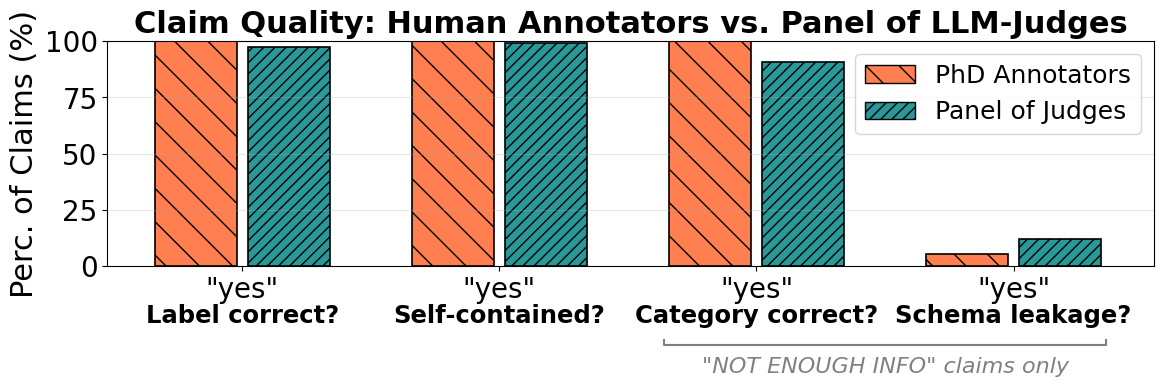

In [ ]:
# Dummy data (percentages)
group1_yes = [human_correct_pct, panel_correct_pct]  # Two "yes" bars
group2_yes = [human_free_of_meta_ref_pct, panel_free_of_meta_ref_pct]  # Two "yes" bars
group3_yes = [human_category_correct_pct, panel_category_correct_pct]  # Two "yes" bars
group4_yes = [human_schema_leakage_pct, panel_schema_leakage_pct]  # Two "yes" bars

# Positions for bars - THIS IS THE ONLY THING YOU NEED TO DEFINE
x = np.array([0, 0.9,         # Group 1
              2.5, 3.4,       # Group 2
              5.0, 5.9,       # Group 3
              7.5, 8.4])      # Group 4

# All values
values = group1_yes + group2_yes + group3_yes + group4_yes

group1_color, group2_color = '#FF7F50', "#289898"
group1_hatch, group2_hatch = '\\', '///'
colors = [group1_color, group2_color] * 4
hatches = [group1_hatch, group2_hatch] * 4

# Create bar plot
fig, ax = plt.subplots(figsize=(13.5, 5))
bars = ax.bar(x, values, color=colors, edgecolor='black', linewidth=1.2)

# Apply hatching pattern to each bar
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Labels
ax.set_ylabel('Perc. of Claims (%)')
ax.set_ylim(0, 100)

# AUTOMATICALLY DERIVE X-TICK POSITIONS
yes1_center = (x[0] + x[1]) / 2
yes2_center = (x[2] + x[3]) / 2
yes3_center = (x[4] + x[5]) / 2
yes4_center = (x[6] + x[7]) / 2

ax.set_xticks([yes1_center, yes2_center, yes3_center, yes4_center])
ax.set_xticklabels(['"yes"', '"yes"', '"yes"', '"yes"'])

# AUTOMATICALLY DERIVE GROUP LABEL POSITIONS
group1_center = (x[0] + x[1]) / 2
group2_center = (x[2] + x[3]) / 2
group3_center = (x[4] + x[5]) / 2
group4_center = (x[6] + x[7]) / 2

ax.text(group1_center, -25, 'Label correct?', ha='center', fontsize=17.5, weight='bold', 
        transform=ax.transData, clip_on=False)
ax.text(group2_center, -25, 'Self-contained?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)
ax.text(group3_center, -25, 'Category correct?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)
ax.text(group4_center, -25, 'Schema leakage?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)

bracket_y = -35
bracket_left = group3_center - 0.9
bracket_right = group4_center + 0.9
ax.plot([bracket_left, bracket_left, bracket_right, bracket_right], 
        [bracket_y+2, bracket_y, bracket_y, bracket_y+2], 
        color='gray', linewidth=1.5, clip_on=False)
ax.text((bracket_left + bracket_right) / 2, bracket_y - 12.5, '"NOT ENOUGH INFO" claims only', 
        ha='center', fontsize=16, style='italic', color='grey', clip_on=False)


# Grid
ax.grid(axis='y', alpha=0.3)

legend_elements = [
    Patch(facecolor=group1_color, edgecolor='black', hatch=group1_hatch, label='PhD Annotators'),
    Patch(facecolor=group2_color, edgecolor='black', hatch=group2_hatch, label='Panel of Judges')
]
ax.legend(handles=legend_elements, loc='best')

plt.title("Claim Quality: Human Annotators vs. Panel of LLM-Judges")
#plt.tight_layout()
plt.subplots_adjust(bottom=0.3, top=0.75)
plt.savefig(config.paper_plots_dir / 'judges_claim_quality_annotaton.pdf', bbox_inches="tight")
plt.show()

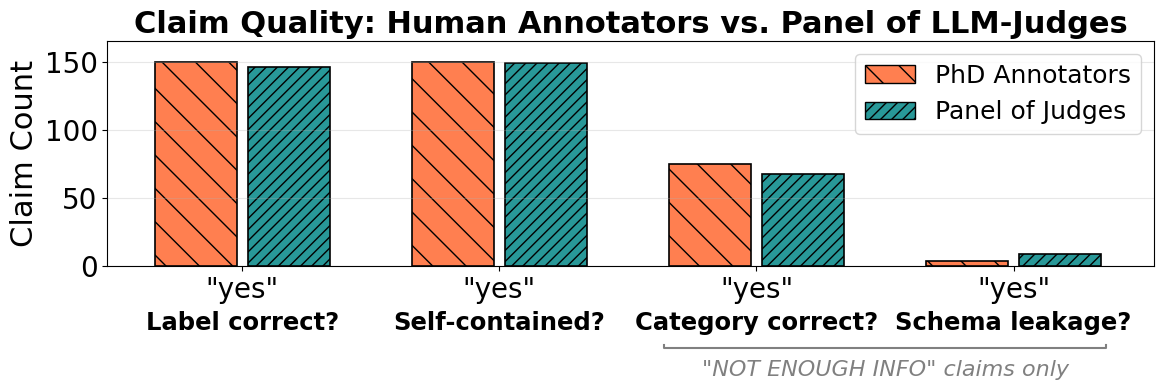

In [ ]:
# Dummy data (counts)
group1_yes = [human_correct, panel_correct]  # Two "yes" bars
group2_yes = [human_free_of_meta_ref, panel_free_of_meta_ref]  # Two "yes" bars
group3_yes = [human_category_correct, panel_category_correct]  # Two "yes" bars
group4_yes = [human_schema_leakage, panel_schema_leakage]  # Two "yes" bars

# Positions for bars - THIS IS THE ONLY THING YOU NEED TO DEFINE
x = np.array([0, 0.9,         # Group 1
              2.5, 3.4,       # Group 2
              5.0, 5.9,       # Group 3
              7.5, 8.4])      # Group 4

# All values
values = group1_yes + group2_yes + group3_yes + group4_yes

group1_color, group2_color = '#FF7F50', "#289898"
group1_hatch, group2_hatch = '\\', '///'
colors = [group1_color, group2_color] * 4
hatches = [group1_hatch, group2_hatch] * 4

# Create bar plot
fig, ax = plt.subplots(figsize=(13.5, 5))
bars = ax.bar(x, values, color=colors, edgecolor='black', linewidth=1.2)

# Apply hatching pattern to each bar
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# Labels
ax.set_ylabel('Claim Count')
ax.set_ylim(0, max(values) * 1.1)

# AUTOMATICALLY DERIVE X-TICK POSITIONS
yes1_center = (x[0] + x[1]) / 2
yes2_center = (x[2] + x[3]) / 2
yes3_center = (x[4] + x[5]) / 2
yes4_center = (x[6] + x[7]) / 2

ax.set_xticks([yes1_center, yes2_center, yes3_center, yes4_center])
ax.set_xticklabels(['"yes"', '"yes"', '"yes"', '"yes"'])

# AUTOMATICALLY DERIVE GROUP LABEL POSITIONS
group1_center = (x[0] + x[1]) / 2
group2_center = (x[2] + x[3]) / 2
group3_center = (x[4] + x[5]) / 2
group4_center = (x[6] + x[7]) / 2

ax.text(group1_center, -47, 'Label correct?', ha='center', fontsize=17.5, weight='bold', 
        transform=ax.transData, clip_on=False)
ax.text(group2_center, -47, 'Self-contained?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)
ax.text(group3_center, -47, 'Category correct?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)
ax.text(group4_center, -47, 'Schema leakage?', ha='center', fontsize=17.5, weight='bold',
        transform=ax.transData, clip_on=False)

bracket_y = -60
bracket_left = group3_center - 0.9
bracket_right = group4_center + 0.9
ax.plot([bracket_left, bracket_left, bracket_right, bracket_right], 
        [bracket_y+2, bracket_y, bracket_y, bracket_y+2], 
        color='gray', linewidth=1.5, clip_on=False)
ax.text((bracket_left + bracket_right) / 2, bracket_y - 20.5, '"NOT ENOUGH INFO" claims only', 
        ha='center', fontsize=16, style='italic', color='grey', clip_on=False)


# Grid
ax.grid(axis='y', alpha=0.3)

legend_elements = [
    Patch(facecolor=group1_color, edgecolor='black', hatch=group1_hatch, label='PhD Annotators'),
    Patch(facecolor=group2_color, edgecolor='black', hatch=group2_hatch, label='Panel of Judges')
]
ax.legend(handles=legend_elements, loc='best')

plt.title("Claim Quality: Human Annotators vs. Panel of LLM-Judges")
#plt.tight_layout()
plt.subplots_adjust(bottom=0.3, top=0.75)
plt.savefig(config.paper_plots_dir / 'judges_claim_quality_annotaton_counts.pdf', bbox_inches="tight")
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()